In [2]:
import os
import random
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
from himalaya.backend import set_backend
from matplotlib import pyplot as plt
import simplstyles

from residual import residual_method
from dataset import generate_dataset
from variance_partitioning import variance_partitioning

In [3]:
def get_path(alphas, cv, n_targets):
    path = os.path.join("results", f"targets={n_targets}", f"cv={cv}",
                        f"alphas={alphas.min()},{alphas.max()},{len(alphas)}", "varying dimensions")
    os.makedirs(path, exist_ok=True)
    return path

In [4]:
def save_scores(d_list_list, scalars, n_targets, n_samples, noise_target, cv, alphas):
    path = get_path(alphas, cv, n_targets)
    for d_list in d_list_list:
        print(d_list)
        csv_path = os.path.join(path, f"scores_{d_list}.csv")
        scores = pd.DataFrame()
        if os.path.exists(csv_path):
            print("skipping, already exists")
            continue
        Xs, Y = generate_dataset(d_list, scalars, n_targets, n_samples, noise_target)
        print("data generated")
        x1_score, x2_score, joint_score, x1_and_x2_score, vp_x1_unique_score, vp_x2_unique_score = variance_partitioning(
            Xs, Y, n_samples_train, alphas, cv)
        print("variance partitioning done")

        scores["x1_score"] = x1_score
        scores["x2_score"] = x2_score
        scores["vp_joint_score"] = joint_score
        scores["vp_shared_score"] = x1_and_x2_score
        scores["vp_x1_unique_score"] = vp_x1_unique_score
        scores["vp_x2_unique_score"] = vp_x2_unique_score
        del x1_score, x2_score, joint_score, x1_and_x2_score, vp_x1_unique_score, vp_x2_unique_score

        x2_to_x1_score, x1_to_x2_score, rm_x1_unique_score, rm_x2_unique_score = residual_method(
            Xs, Y, n_samples_train, alphas, cv)
        print("residual method done")
        scores["rm_x2_to_x1_score"] = np.concatenate(
            [x2_to_x1_score, np.full(len(rm_x1_unique_score) - len(x2_to_x1_score), np.nan)])
        scores["rm_x1_to_x2_score"] = np.concatenate(
            [x1_to_x2_score, np.full(len(rm_x1_unique_score) - len(x1_to_x2_score), np.nan)])
        scores["rm_x1_unique_score"] = rm_x1_unique_score
        scores["rm_x2_unique_score"] = rm_x2_unique_score
        del x2_to_x1_score, x1_to_x2_score, rm_x1_unique_score, rm_x2_unique_score

        # ridge residual
        x2_to_x1_ridge_score, x1_to_x2_ridge_score, rm_ridge_x1_unique_score, rm_ridge_x2_unique_score = residual_method(
            Xs, Y, n_samples_train, alphas, cv, use_ols=False)
        print("residual method done")
        scores["rm_ridge_x2_to_x1_score"] = np.concatenate(
            [x2_to_x1_ridge_score, np.full(len(rm_ridge_x1_unique_score) - len(x2_to_x1_ridge_score), np.nan)])
        scores["rm_ridge_x1_to_x2_score"] = np.concatenate(
            [x1_to_x2_ridge_score, np.full(len(rm_ridge_x1_unique_score) - len(x1_to_x2_ridge_score), np.nan)])
        scores["rm_ridge_x1_unique_score"] = rm_ridge_x1_unique_score
        scores["rm_ridge_x2_unique_score"] = rm_ridge_x2_unique_score
        del x2_to_x1_ridge_score, x1_to_x2_ridge_score, rm_ridge_x1_unique_score, rm_ridge_x2_unique_score

        del Xs, Y
        scores.to_csv(csv_path, index=False)

# Save scores for varying Dimensions

In [5]:
backend = set_backend("torch_cuda", on_error="warn")
warnings.filterwarnings("ignore")
random.seed(42)
plt.style.use('nord-light-talk')

In [6]:
d_list = [100, 100, 100]
n_targets = 10000
n_samples_train = 10000
n_samples_test = 10000
n_samples = n_samples_train + n_samples_test
noise_target = 0.1
scalars = [1 / 3, 1 / 3, 1 / 3]

cv = 10
alphas = np.logspace(-5, 5, 10)

In [7]:
varying_dim = np.logspace(1, 3, 10, dtype=int)
varying_dim = list(map(int, varying_dim))

## Shared dimension

In [8]:
d_list_list = [[dim, d_list[1], d_list[2]] for dim in varying_dim]

In [9]:
save_scores(d_list_list, scalars, n_targets, n_samples, noise_target, cv, alphas)

[10, 100, 100]
skipping, already exists
[16, 100, 100]
skipping, already exists
[27, 100, 100]
skipping, already exists
[46, 100, 100]
skipping, already exists
[77, 100, 100]
skipping, already exists
[129, 100, 100]
skipping, already exists
[215, 100, 100]
skipping, already exists
[359, 100, 100]
skipping, already exists
[599, 100, 100]
skipping, already exists
[1000, 100, 100]
skipping, already exists


## Unique dimension

In [10]:
d_list_list = [[d_list[0], int(dim), d_list[2]] for dim in varying_dim]

In [11]:
save_scores(d_list_list, scalars, n_targets, n_samples, noise_target, cv, alphas)

[100, 10, 100]
skipping, already exists
[100, 16, 100]
skipping, already exists
[100, 27, 100]
skipping, already exists
[100, 46, 100]
skipping, already exists
[100, 77, 100]
skipping, already exists
[100, 129, 100]
skipping, already exists
[100, 215, 100]
skipping, already exists
[100, 359, 100]
skipping, already exists
[100, 599, 100]
skipping, already exists
[100, 1000, 100]
skipping, already exists


# Plot scores

## Shared dimension

In [19]:
vp = pd.DataFrame()
rm = pd.DataFrame()
rm_ridge = pd.DataFrame()

for i, dim in enumerate(varying_dim):
    shared_dims = [dim, d_list[1], d_list[2]]
    scores = pd.read_csv(os.path.join(get_path(alphas, cv, n_targets), f"scores_{shared_dims}.csv"))

    vp_scores = pd.DataFrame({
        'shared_dim': [dim] * len(scores),
        'vp_x1_unique_score': scores['vp_x1_unique_score'],
    }, index=range(len(scores)))

    rm_scores = pd.DataFrame({
        'shared_dim': [dim] * len(scores),
        'rm_x1_unique_score': scores['rm_x1_unique_score'],
    }, index=range(len(scores)))

    rm_ridge_scores = pd.DataFrame({
        'shared_dim': [dim] * len(scores),
        'rm_ridge_x1_unique_score': scores['rm_ridge_x1_unique_score'],
    })

    vp = pd.concat([vp, vp_scores], ignore_index=True)
    rm = pd.concat([rm, rm_scores], ignore_index=True)
    rm_ridge = pd.concat([rm_ridge, rm_ridge_scores], ignore_index=True)
rm

,shared_dim,rm_x1_unique_score
0,10,0.277787
1,10,0.286266
2,10,0.297698
3,10,0.287039
4,10,0.291210
...,...,...
99995,1000,0.223859
99996,1000,0.248753
99997,1000,0.220167
99998,1000,0.207897


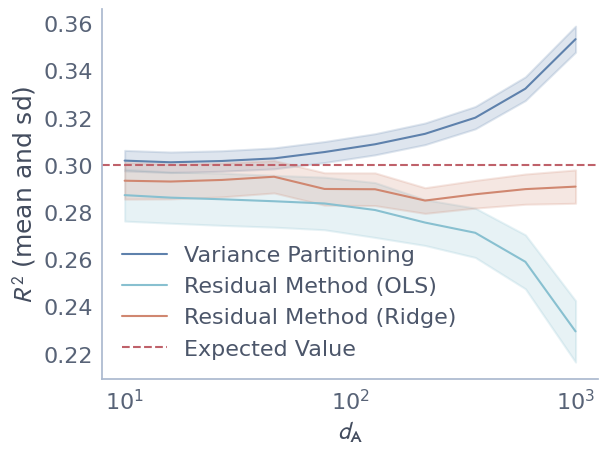

In [20]:
sns.lineplot(data=vp, x='shared_dim', y='vp_x1_unique_score', label='Variance Partitioning', errorbar='sd')
sns.lineplot(data=rm, x='shared_dim', y='rm_x1_unique_score', label='Residual Method (OLS)', errorbar='sd')
sns.lineplot(data=rm_ridge, x='shared_dim', y='rm_ridge_x1_unique_score', label='Residual Method (Ridge)', errorbar='sd')
plt.axhline(scalars[1] * (1 - noise_target), linestyle='--', label='Expected Value', color="C3")
plt.xlabel(r"$d_\mathbf{A}$")
plt.ylabel(r"$R^2$ (mean and sd)")
plt.xscale('log')
plt.legend()

## Unique dimension

In [14]:
vp = pd.DataFrame()
rm = pd.DataFrame()
rm_ridge = pd.DataFrame()

for i, dim in enumerate(varying_dim):
    unique_dims = [d_list[0], dim, d_list[2]]
    scores = pd.read_csv(os.path.join(get_path(alphas, cv, n_targets), f"scores_{unique_dims}.csv"))

    vp_scores = pd.DataFrame({
        'unique_dim': [dim] * len(scores),
        'vp_x1_unique_score': scores['vp_x1_unique_score'],
    }, index=range(len(scores)))

    rm_scores = pd.DataFrame({
        'unique_dim': [dim] * len(scores),
        'rm_x1_unique_score': scores['rm_x1_unique_score'],
    }, index=range(len(scores)))

    rm_ridge_scores = pd.DataFrame({
        'unique_dim': [dim] * len(scores),
        'rm_ridge_x1_unique_score': scores['rm_ridge_x1_unique_score'],
    }, index=range(len(scores)))

    vp = pd.concat([vp, vp_scores], ignore_index=True)
    rm = pd.concat([rm, rm_scores], ignore_index=True)
    rm_ridge = pd.concat([rm_ridge, rm_ridge_scores], ignore_index=True)

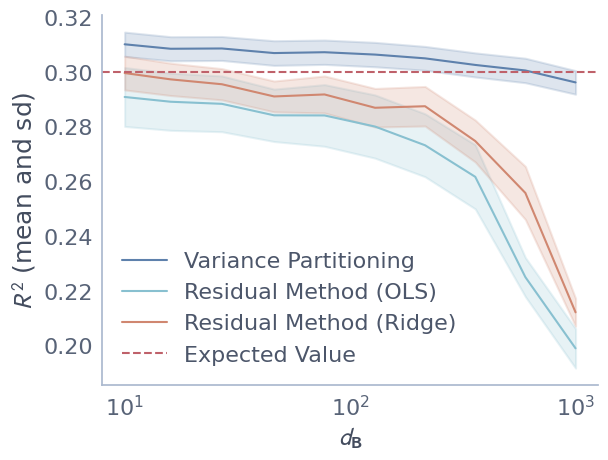

In [17]:
sns.lineplot(data=vp, x='unique_dim', y='vp_x1_unique_score', label='Variance Partitioning', errorbar='sd')
sns.lineplot(data=rm, x='unique_dim', y='rm_x1_unique_score', label='Residual Method (OLS)', errorbar='sd')
sns.lineplot(data=rm_ridge, x='unique_dim', y='rm_ridge_x1_unique_score', label='Residual Method (Ridge)', errorbar='sd')
plt.axhline(scalars[1] * (1 - noise_target), linestyle='--', label='Expected Value', color="C3")
plt.xlabel(r"$d_\mathbf{B}$")
plt.ylabel(r"$R^2$ (mean and sd)")
plt.xscale('log')
plt.legend()